# Shipwrecked: The (Toy) Game

### By Sahitya Senapathy

## Overview

Welcome to Shipwrecked, a simple optimization game.

You are stranded on an island with no food. You can stay on the beach, where you'll be safe... until you die of starvation. Or you can go into the jungle. But be wary, if you venture in, you may not leave alive.

## Code

### Environment

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt 

In [2]:
class Island:
    def __init__(self):
        # days_left = number of days you can survive without food
        self.days_left = None # number of days agent can survive w/o food
        self.max_days = 8.0 # max number of days survive w/o food
        self.die_prob = 0.3 # prob die if jungle

    def reset(self):
        self.days_left = 5.0  # start out with 5 days of strength
        return [self.days_left, 0.0]

    def is_starved(self):
        return self.days_left == 0.0  # if you starve, you die

    def step(self, action):
        self.days_left -= 1.0  # count one day down
        if action == 0:  # if you stay on the beach
            if self.is_starved():  # if you've starved
                return [0.0, 0.0], 0, True, {}  # return observation, reward, dead
            else:
                return [self.days_left, 0.0], 1, False, {}
        elif action == 1:  # if go into jungle
            if random.uniform(0, 1) < self.die_prob:  # 30 percent chance you die
                return [0.0, 0.0], 0, True, {}
            else:
                self.days_left += 5.0
                if self.days_left > self.max_days:
                    self.days_left = self.max_days  # life boosted to 8 days (capped)
                return [self.days_left, 0.0], 1, False, {}

### Q-Learning

In [3]:
env = Island()
q_table = np.zeros((int(env.max_days), 2))
learning_rate = 0.1

exploration_rate = 1 #exploration rate
max_e = 1
min_e = 0.01
e_decay = 0.001

num_episodes = 50000
num_steps = 30

rewards_q = []
temp_actions = []

#### Ɛ-greedy (with Ɛ decay)

In [4]:
print('Q-Learning with Ɛ decay:')
for episode in range(1, num_episodes+1):
    if episode % (num_episodes/10) == 0:
        print(f'{episode} games played')
    obs = env.reset() # reset the environment for each episode
    obs = int(obs[0])
    done = False # if episode is done
    curr_reward = 0 # current episode reward
    
    for step in range(num_steps):     
        # exploit current knowledge
        if random.uniform(0,1) > exploration_rate:
            action = np.argmax(q_table[obs-1,:])
        # explore random option
        else:
            action = random.sample((0, 1), 1)[0]
        
        next_obs, reward, done, info = env.step(action)
        next_obs = int(next_obs[0])
        #update q-table
        q_table[obs-1, action] = (q_table[obs-1, action]*(1 - learning_rate) + 
                                  learning_rate*(reward + 0.99 * np.max(q_table[next_obs-1, :])))
        
        # set next state
        obs = next_obs
        # add reward to episode reward
        curr_reward += reward
        
        if done == True:
            break
        
    # add reward to total rewards
    rewards_q.append(curr_reward)

    # discount exploration rate
    exploration_rate = min_e + (max_e - min_e) * np.exp(-e_decay*episode)

Q-Learning with Ɛ decay:
5000 games played
10000 games played
15000 games played
20000 games played
25000 games played
30000 games played
35000 games played
40000 games played
45000 games played
50000 games played


#### Ɛ-greedy (with constant Ɛ)

In [5]:
q_table2 = np.zeros((int(env.max_days), 2))

rewards_q2 = []
temp_actions2 = []

exploration_rate = 1 #exploration rate

In [6]:
print('Q-Learning without constant Ɛ:')
for episode in range(1, num_episodes+1):
    if episode % (num_episodes/10) == 0:
        print(f'{episode} games played')
    obs = env.reset() # reset the environment for each episode
    obs = int(obs[0])
    done = False # if episode is done
    curr_reward = 0 # current episode reward
    
    for step in range(num_steps):     
        # exploit current knowledge
        if random.uniform(0,1) > exploration_rate:
            action = np.argmax(q_table[obs-1,:])
        # explore random option
        else:
            action = random.sample((0, 1), 1)[0]
        
        next_obs, reward, done, info = env.step(action)
        next_obs = int(next_obs[0])
                
        #update q-table
        q_table2[obs-1, action] = (q_table2[obs-1, action]*(1 - learning_rate) + 
                                  learning_rate*(reward + 0.99 * np.max(q_table2[next_obs-1, :])))
        
        # set next state
        obs = next_obs
        # add reward to episode reward
        curr_reward += reward
        
        if done == True:
            break
        
    # add reward to total rewards
    rewards_q2.append(curr_reward)

Q-Learning without constant Ɛ:
5000 games played
10000 games played
15000 games played
20000 games played
25000 games played
30000 games played
35000 games played
40000 games played
45000 games played
50000 games played


### Cross-Entropy

In [7]:
from collections import namedtuple

import torch
import torch.nn as nn
import torch.optim as optim

In [8]:
layer_size = 128
batch_size = 100
percentile = 70

In [9]:
class Net(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x)

In [10]:
Episode = namedtuple('Episode', ('reward', 'steps'))
EpisodeStep = namedtuple('EpisodeStep', ('observation', 'action'))
rewards_ce = []

In [11]:
def iterate_batches(env, net, batch_size):
    batch = []
    episode_steps = []
    sm = nn.Softmax(dim=1)

    obs = env.reset()
    done = False
    curr_reward = 0
    
    exploration_rate = 1
    
    while True:
        obs_v = torch.FloatTensor([obs])
        act_probs_v = sm(net(obs_v))
        act_probs = act_probs_v.data.numpy()[0]
        
        if random.uniform(0,1) > exploration_rate:
            action = np.random.choice(len(act_probs), p=act_probs)
        else:
            action = random.sample((0, 1), 1)[0]
        
        next_obs, reward, done, info = env.step(action)
        curr_reward += reward

        step = EpisodeStep(obs, action)
        episode_steps.append(step)
        
        if done == True:
            exploration_rate *= 0.999
            rewards_ce.append(curr_reward)
            e = Episode(curr_reward, episode_steps)
            batch.append(e)
            
            curr_reward = 0
            episode_steps = []
            
            next_obs = env.reset()
            
            if len(batch) == batch_size:
                yield batch
                batch = []
        obs = next_obs

In [12]:
def filter_batch(batch, percentile):
    rewards = list(map(lambda s: s.reward, batch))
    reward_bound = np.percentile(rewards, percentile)
    train_obs = []
    train_act = []
    for reward, steps in batch:
        if reward < reward_bound:
            continue
        train_obs.extend(map(lambda step: step.observation, steps))
        train_act.extend(map(lambda step: step.action, steps))

    train_obs_v = torch.FloatTensor(train_obs)
    train_act_v = torch.LongTensor(train_act)
    return train_obs_v, train_act_v

In [13]:
obs_size = 2
n_actions = 2
net = Net(obs_size, layer_size, n_actions)
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.01)

for iter_no, batch in enumerate(iterate_batches(env, net, batch_size)):
    if iter_no % (num_episodes/1000) == 0:
        print(f'{iter_no*100} games played')
    obs_v, acts_v = filter_batch(batch, percentile)
    optimizer.zero_grad()
    action_scores_v = net(obs_v)
    loss_v = objective(action_scores_v, acts_v)
    loss_v.backward()
    optimizer.step()
    if iter_no > 499:
        break

0 games played
5000 games played
10000 games played
15000 games played
20000 games played
25000 games played
30000 games played
35000 games played
40000 games played
45000 games played
50000 games played


### Training Results

#### Rough rewards

In [18]:
increment = 10
increment_count = int(num_episodes/increment)

# split rewards into bins
ir_q = np.array_split(np.array(rewards_q), increment_count)
ir_q2 = np.array_split(np.array(rewards_q2), increment_count)
ir_ce = np.array_split(np.array(rewards_ce), increment_count)

# rewards array
inc_rewards_q = np.zeros(increment_count)
inc_rewards_q2 = np.zeros(increment_count)
inc_rewards_ce = np.zeros(increment_count)

for i in range(increment_count):
    inc_rewards_q[i] = sum(ir_q[i]/increment)
    inc_rewards_q2[i] = sum(ir_q2[i]/increment)
    inc_rewards_ce[i] = sum(ir_ce[i]/increment)

#### Smoothed rewards

In [19]:
smooth_increment = 100
smooth_count = int(num_episodes/smooth_increment)

# split rewards into bins
sr_q = np.array_split(np.array(rewards_q), smooth_count)
sr_q2 = np.array_split(np.array(rewards_q2), smooth_count)
sr_ce = np.array_split(np.array(rewards_ce), smooth_count)

# rewards array
s_rewards_q = np.zeros(smooth_count)
s_rewards_q2 = np.zeros(smooth_count)
s_rewards_ce = np.zeros(smooth_count)

for i in range(smooth_count):
    s_rewards_q[i] = sum(sr_q[i]/smooth_increment)
    s_rewards_q2[i] = sum(sr_q2[i]/smooth_increment)
    s_rewards_ce[i] = sum(sr_ce[i]/smooth_increment)

#### Averaged rewards

In [20]:
av_increment = 1000
av_count = int(num_episodes/av_increment)

ar_q = np.array_split(np.array(rewards_q), av_count)
ar_q2 = np.array_split(np.array(rewards_q2), av_count)
ar_ce = np.array_split(np.array(rewards_ce), av_count)

print('Average reward per thousand episodes')
print()

print('Ɛ decay:')
for i in range(av_count):
    print(f'({i*av_increment}): {sum(ar_q[i]/av_increment)}')
print()

print('constant Ɛ:')    
for i in range(av_count):
    print(f'({i*av_increment}): {sum(ar_q2[i]/av_increment)}')
print()

print('Cross-Entropy:')
for i in range(av_count):
    print(f'({i*av_increment}): {sum(ar_ce[i]/av_increment)}')

Average reward per thousand episodes

Ɛ decay:
(0): 4.5289999999999555
(1000): 5.123999999999955
(2000): 5.602999999999995
(3000): 7.269999999999927
(4000): 8.564999999999927
(5000): 9.576999999999968
(6000): 10.954999999999979
(7000): 10.703999999999986
(8000): 10.607999999999976
(9000): 11.784999999999961
(10000): 11.49499999999998
(11000): 11.434999999999958
(12000): 11.596999999999973
(13000): 12.224999999999948
(14000): 11.550999999999949
(15000): 12.06799999999998
(16000): 11.984999999999898
(17000): 12.785999999999918
(18000): 12.629999999999923
(19000): 12.690999999999928
(20000): 13.49299999999989
(21000): 12.636999999999933
(22000): 12.948999999999929
(23000): 12.369999999999942
(24000): 12.434999999999933
(25000): 13.018999999999933
(26000): 12.551999999999918
(27000): 12.731999999999928
(28000): 12.416999999999934
(29000): 12.684999999999924
(30000): 12.729999999999924
(31000): 13.107999999999944
(32000): 12.03199999999993
(33000): 13.03799999999993
(34000): 12.763999999999

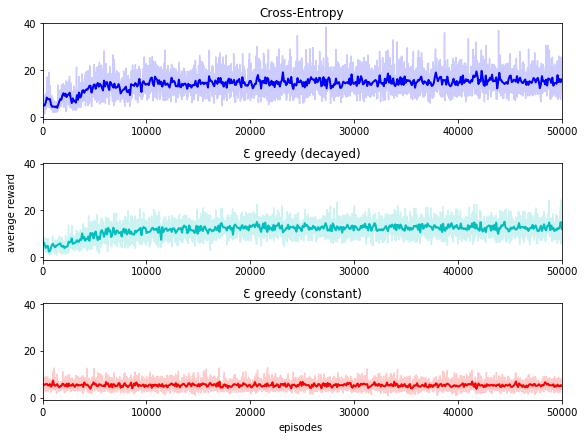

In [89]:
x2 = np.linspace(0, num_episodes, int(num_episodes/increment)) #rough
x1 = np.linspace(0, num_episodes, int(num_episodes/smooth_increment*1.0)) #smooth

fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=True, figsize=(8,6))
# cross entropy
ax1.plot(x2, inc_rewards_ce, color='#0000FF', alpha=0.2);
ax1.plot(x1, s_rewards_ce, color='#0000FF', linewidth=2, label='Cross-Entropy');
ax1.set_xlim(0, 50000);
ax1.set_title('Cross-Entropy')
# q learning 1
ax2.plot(x2, inc_rewards_q, color='#00BFBF', alpha=0.2);
ax2.plot(x1, s_rewards_q, color='#00BFBF', linewidth=2, label='Ɛ decay');
ax2.set_xlim(0, 50000);
ax2.set_title('Ɛ greedy (decayed)')
#q learning 2
ax3.plot(x2, inc_rewards_q2, color='#FF0000', alpha=0.2);
ax3.plot(x1, s_rewards_q2, color='#FF0000', linewidth=2, label='constant Ɛ');
ax3.set_xlim(0, 50000);
ax3.set_title('Ɛ greedy (constant)')

fig.text(0.5, 0, 'episodes', ha='center', va='center')
fig.text(0, 0.5, 'average reward', ha='center', va='center', rotation='vertical')

fig.tight_layout()

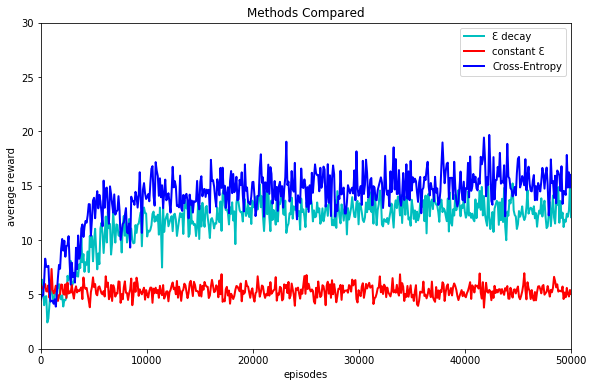

In [92]:
plt.figure(figsize=(9.5, 6))

plt.plot(x1, s_rewards_q, color='#00BFBF', linewidth=2, label='Ɛ decay');
plt.plot(x1, s_rewards_q2, color='#FF0000', linewidth=2, label='constant Ɛ');
plt.plot(x1, s_rewards_ce, color='#0000FF', linewidth=2, label='Cross-Entropy');

plt.legend()
plt.xlim(0,50000);
plt.ylim(0, 30);
plt.xlabel('episodes');
plt.ylabel('average reward');
plt.title('Methods Compared');